# Implementing a Recommender System using LightGCN

In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from modeling.sampling import sample_minibatch
from modeling.metrics import calculate_metrics
from modeling.losses import BPR_loss
from modeling.models.simple import GNN
from torch_geometric.utils import to_undirected

import time

import torch
from torch import optim

In [2]:
# Lets start by loading the data
data = torch.load("data/hetero_data_no_coauthor.pt", weights_only=False)

# We only need the edges for light GCN
edge_index = data["author", "writes", "paper"].edge_index
paper_ids = data["paper"].node_id
paper_embeddings = data["paper"].x
author_ids = data["author"].node_id
author_embeddings = torch.ones((len(author_ids), 256))  # dummy features

print(f"Number of authors: {len(author_ids)}")
print(f"Number of papers: {len(paper_ids)}")
print(f"Number of edges: {edge_index.shape[1]}")

Number of authors: 90941
Number of papers: 63854
Number of edges: 320187


In [3]:
# # shift the edge index for papers
edge_index[1, :] += len(author_ids)
paper_ids += len(author_ids)
unique_paper_ids = torch.unique(paper_ids)

node_ids = torch.cat([author_ids, paper_ids], dim=0)
embeddings = torch.cat([author_embeddings, paper_embeddings], dim=0)

In [4]:
# split the edges of the graph using a 80/10/10 train/validation/test split
num_authors, num_papers = len(author_ids), len(paper_ids)
num_interactions = edge_index.shape[1]
all_indices = [i for i in range(num_interactions)]

# Here we enumearte the edges
# Then we split them into train, val, test sets
train_indices, test_indices = train_test_split(
    all_indices,
    test_size=0.2,
    random_state=1,
)
train_message_passing_indiceies, train_supervision_indices = train_test_split(
    train_indices,
    test_size=0.3,
    random_state=1,
)
val_indices, test_indices = train_test_split(
    test_indices,
    test_size=0.5,
    random_state=1,
)

train_message_passing_edge_index = edge_index[:, train_message_passing_indiceies]
train_supervision_edge_index = edge_index[:, train_supervision_indices]
train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

train_message_passing_edge_index = to_undirected(train_message_passing_edge_index)

In [5]:
# define contants
ITERATIONS = 100000
BATCH_SIZE = 1024
LR = 1e-3
ITERS_PER_EVAL = 1000
K = 20

# setup
model = GNN(
    embedding_dim=embeddings.shape[1],
    num_layers=5,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}.")


model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
train_message_passing_edge_index = train_message_passing_edge_index.to(device)
train_supervision_edge_index = train_supervision_edge_index.to(device)
val_edge_index = val_edge_index.to(device)
unique_paper_ids = unique_paper_ids.to(device)

embeddings = embeddings.to(device)

# training loop
train_losses = []
batching_times = []
forward_times = []
loss_times = []
backward_times = []

Using device cuda.


In [6]:
# define contants
ITERATIONS = 100000

for iter in range(ITERATIONS):
    print(f"Iteration {iter + 1}/{ITERATIONS} | Average Loss over last 100 iters: {sum(train_losses[-100:])/len(train_losses[-100:]) if len(train_losses) > 0 else 0:.5f}", end="\r")

    # mini batching
    start_time = time.time()
    pos_edge_index, neg_edge_index = sample_minibatch(
        train_supervision_edge_index,
        unique_paper_ids,
        BATCH_SIZE,
        neg_sample_ratio=10,
    )
    pos_edge_index = pos_edge_index.to(device)
    neg_edge_index = neg_edge_index.to(device)
    batching_times.append(time.time() - start_time)

    # forward propagation
    start_time = time.time()
    updated_embeddings = model.forward(
        x=embeddings,
        edge_index=train_message_passing_edge_index,
    )
    
    author_embeddings, paper_embeddings = torch.split(
        embeddings,
        [num_authors, num_papers],
        dim=0,
    )
    
    
    forward_times.append(time.time() - start_time)

    pos_scores = torch.sum(
        updated_embeddings[pos_edge_index[0, :]]
        * updated_embeddings[pos_edge_index[1, :]],
        dim=1,
    )
    neg_scores = torch.sum(
        updated_embeddings[neg_edge_index[0, :]]
        * updated_embeddings[neg_edge_index[1, :]],
        dim=1,
    )

    # loss computation
    start_time = time.time()
    train_loss = BPR_loss(
        pos_scores,
        neg_scores,
    )
    loss_times.append(time.time() - start_time)

    # backward propagation
    start = time.time()
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    backward_times.append(time.time() - start)
    
    train_losses.append(train_loss.item())
    

    if (iter + 1) % ITERS_PER_EVAL == 0:
        model.eval()

        with torch.no_grad():
            # typically we would use the supervising edges as well here
            # But LightGCN does not have parameters, it only learns from the edges we use during training is is fix after that
            updated_embeddings = model.forward(
                x=embeddings,
                edge_index=train_message_passing_edge_index,
            )
            forward_times.append(time.time() - start_time)

            author_embeddings, paper_embeddings = torch.split(
                updated_embeddings,
                [num_authors, num_papers],
                dim=0,
            )

        shifted_val_edge_index = val_edge_index.clone()
        shifted_val_edge_index[1, :] -= num_authors
        

        shifted_train_edge_index = train_edge_index.clone()
        shifted_train_edge_index[1, :] -= num_authors

        shifted_train_supervision_edge_index = train_supervision_edge_index.clone()
        shifted_train_supervision_edge_index[1, :] -= num_authors

        shifted_train_message_passing_edge_index = (
            train_message_passing_edge_index.clone()
        )
        shifted_train_message_passing_edge_index[1, :] -= num_authors

        val_recall, val_precision = calculate_metrics(
            author_embeddings,
            paper_embeddings,
            shifted_val_edge_index,
            [shifted_train_edge_index],
            K,
            batch_size=1024,
        )

        train_recall, train_precision = calculate_metrics(
            author_embeddings,
            paper_embeddings,
            shifted_train_supervision_edge_index,
            [shifted_train_message_passing_edge_index],
            K,
            batch_size=1024,
        )

        print(
            f"[Iteration {iter + 1}/{ITERATIONS}] train_loss: {train_loss.item():.05f}, val_recall@{K}: {val_recall:.05f}, val_precision@{K}: {val_precision:.05f}, train_recall@{K}: {train_recall:.05f}, train_precision@{K}: {train_precision:.05f}"
        )
        model.train()
        
# Best layer = 8: [Iteration 10000/10000] train_loss: 0.08947, val_recall@20: 0.02844, val_precision@20: 0.00221, train_recall@20: 0.03590, train_precision@20: 0.00380


[Iteration 1000/100000] train_loss: 0.35996, val_recall@20: 0.00506, val_precision@20: 0.00035, train_recall@20: 0.00517, train_precision@20: 0.00051


KeyboardInterrupt: 

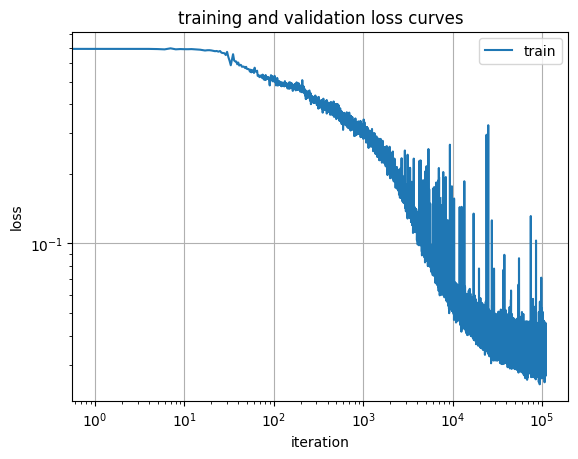

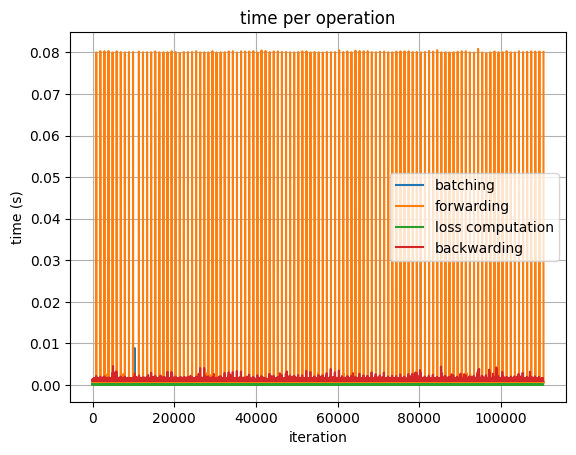

In [ ]:
# save the train_loss curve
import json
with open("train_losses.json", "w") as f:
    json.dump(train_losses, f)

plt.plot(train_losses, label="train")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("training and validation loss curves")
plt.legend()
plt.grid()
plt.yscale("log")
plt.xscale("log")
plt.savefig("training_loss_curve.png")
plt.show()

plt.plot(batching_times[100:], label="batching")
plt.plot(forward_times[100:], label="forwarding")
plt.plot(loss_times[100:], label="loss computation")
plt.plot(backward_times[100:], label="backwarding")
plt.xlabel("iteration")
plt.ylabel("time (s)")
plt.title("time per operation")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# [test_recall@20: 0.07359, test_precision@20: 0.00605

model.eval()
test_edge_index = test_edge_index.to(device)

with torch.no_grad():
    # with torch.no_grad():
    #     user_embedding, item_embedding = model.forward(train_message_passing_edge_index)

    # test_recall, test_precision = calculate_metrics(
    #     user_embedding,
    #     item_embedding,
    #     test_edge_index,
    #     [train_edge_index, val_edge_index],
    #     K,
    #     batch_size=1024,
    # )

        # typically we would use the supervising edges as well here
        # But LightGCN does not have parameters, it only learns from the edges we use during training is is fix after that
    updated_embeddings = model.forward(
        x=embeddings,
        edge_index=train_message_passing_edge_index,
    )
    forward_times.append(time.time() - start_time)

    author_embeddings, paper_embeddings = torch.split(
        updated_embeddings,
        [num_authors, num_papers],
        dim=0,
    )

    shifted_val_edge_index = val_edge_index.clone()
    shifted_val_edge_index[1, :] -= num_authors

    shifted_train_edge_index = train_edge_index.clone()
    shifted_train_edge_index[1, :] -= num_authors

    shifted_test_edge_index = test_edge_index.clone()
    shifted_test_edge_index[1, :] -= num_authors

    test_recall, test_precision = calculate_metrics(
        author_embeddings,
        paper_embeddings,
        shifted_test_edge_index,
        [shifted_train_edge_index, shifted_val_edge_index],
        K,
        batch_size=1024,
    )

print(
    f"[test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}"
)

[test_recall@20: 0.07359, test_precision@20: 0.00605
